# Dense neural network with PyTorch
Authors: Javier Duarte, Tyler Mitchell 

In [1]:
import torch
import numpy as np
import pandas as pd
import uproot

In [2]:
# Copy TTree HZZ4LeptonsAnalysisReduced into a pandas DataFrame
treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.root'
filename['bkg'] = 'data/ntuple_4mu_bkg.root'

# Drop all variables except for those we want to use when training.
VARS = ['f_mass4l','f_massjj']

upfile['VV'] = uproot.open(filename['VV'])
upfile['bkg'] = uproot.open(filename['bkg'])

df['bkg'] = upfile['bkg'][treename].pandas.df(branches=VARS)
df['VV'] = upfile['VV'][treename].pandas.df(branches=VARS)

In [3]:
# Make sure the inputs are well behaved.
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

In [4]:
# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

In [5]:
# Combine signal and background into one DataFrame then split into input variables and labels.
NDIM = len(VARS)
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

# Split into training and testing data.
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print(X_train_val)
print(X)

# preprocessing: standard scalar (reshape inputs to mean=0, variance=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Split again, this time into training and validation data.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=7)

[[ 123.59499359 1071.21447754]
 [ 124.97003174 1074.65454102]
 [ 124.32479095  643.70874023]
 ...
 [  87.93131256  538.8001709 ]
 [ 120.99951935  772.50964355]
 [  90.16904449  194.7850647 ]]
[[ 125.07710266 1300.42687988]
 [ 124.2381134   437.22186279]
 [ 124.48066711 1021.74407959]
 ...
 [  89.28808594   53.66157913]
 [ 146.75657654   71.16202545]
 [ 218.86941528   98.91469574]]


In [6]:
# Build our model. 
import torch
model = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

# Use Binary Cross Entropy as our loss function.
loss_fn = torch.nn.BCELoss()

# Optimize the model parameters using the Adam optimizer.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [8]:
losses, val_losses = [], []
min_loss, stale_epochs = 100., 0

# 500 epochs. 
batch_size = 1024
for t in range(500):
    batch_loss, val_batch_loss = [], []
    
    for b in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[b:b+batch_size]
        Y_batch = Y_train[b:b+batch_size]
        x = torch.from_numpy(X_batch).float()
        y_b = torch.from_numpy(Y_batch).float()
        y_b = y_b.view(-1, 1)
        
        # Forward pass: make a prediction for each x event in batch b.
        y_pred = model(x)

        # Get the labels.
        label = y_b
        y = label.view_as(y_pred)  # reshape label data to the shape of y_pred

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        batch_loss.append(loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        # Let's look at the validation set.
        
        # Torch keeps track of each operation performed on a Tensor, so that it can take the gradient later.
        # We don't need to store this information when looking at validation data, so turn it off with
        # torch.no_grad().
        with torch.no_grad():
            
            # Forward pass on validation set.
            output = model(val_data)

            # Get labels and compute loss again
            val_y = val_label.view_as(output)
            val_loss = loss_fn(output, val_y)
            val_batch_loss.append(val_loss.item())

            # Monitor the loss function to prevent overtraining.
            if stale_epochs > 20:
                break

            if val_loss.item() - min_loss < 0:
                min_loss = val_loss.item()
                stale_epochs = 0
                torch.save(model.state_dict(),'pytorch_model_best.pth')
            else:
                stale_epochs += 1
        
    losses.append(np.mean(batch_loss))
    val_losses.append(np.mean(val_batch_loss))

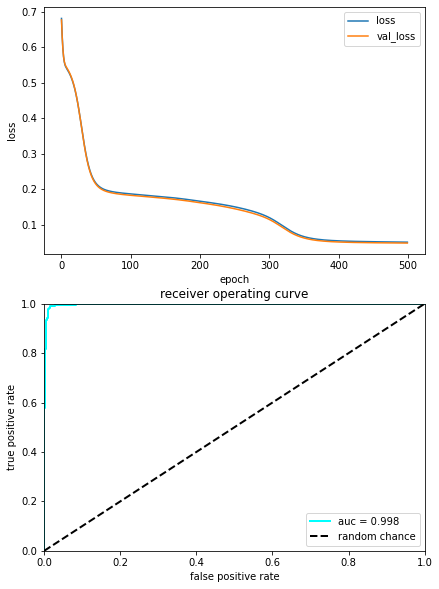

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 2, 1)
    ax.plot(losses, label='loss')
    ax.plot(val_losses, label='val_loss')
    ax.legend(loc="upper right")
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    
    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    ax = plt.subplot(2, 2, 3)
    ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('receiver operating curve')
    ax.legend(loc="lower right")
    plt.show()

In [10]:
# make a regular 2D grid for the inputs
myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)
myZI = model(torch.from_numpy(np.c_[myXI.ravel(), myYI.ravel()]).float())
myZI = myZI.reshape(myXI.shape)

(200, 200)


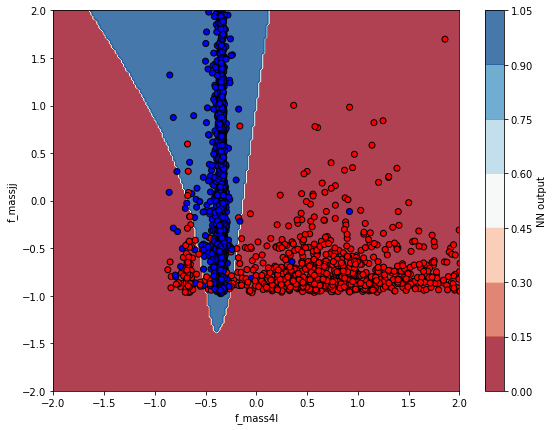

In [11]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points